# Reacher

---

In this notebook we explore the Unity ML-Agents environment, reacher for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). We solve the environment using soft actor critic learning.

## 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment! You will see a new window opening which displays the current view of the environment. As the agent interacts with the environment you will be able to see the activity of the agent. The notebook has been developed on Linux (Ubuntu 18.04) but this should work on Mac and Windows too.

In [2]:
import platform

environment_files = {"Linux":"./Reacher_Linux/Reacher.x86_64", "Darwin":"./Reacher_Mac/Reacher.app", "Windows":"./Reacher_Windows_x86_64/Reacher.exe"}
env = UnityEnvironment(file_name=environment_files[platform.system()])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

The simulation contains a single agent that controls a robot arm.  At each time step, it chooses four forces to apply as torques to its two joints. The actions are then a four dimensional vector with values between -1 and 1.

The state space has `26` variables corresponding to position, rotation, velocity, and angular velocities of the two arm Rigidbodies.  A reward of `+0.1` is provided for each timestep that the arm is in goal position.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Action space dimension:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Action space dimension: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33


## 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


## 4. Train the agents

The cells below setup the code for training an agent to solve the environment. We save the policy network weights into a pth file `sac_policy.pth`).

In [20]:
# Imports and setup plotting
import importlib
import collections
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Agent code
import agent
importlib.reload(agent)

%matplotlib notebook

In [21]:
# The main training loop 
def train(agent, weights_file, n_episodes=1000, max_t=1000):
    scores = []                        # list containing scores from each episode
    scores_window = collections.deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        score = agent.learn_episode(max_t)
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.policy_net.state_dict(), weights_file)
            break
    return scores

### Soft Actor Critic

For this agent we use a basic soft actor critic implementation. The main concepts behind SAC are as follows:

- Off policy. We use a buffer to store recent experiences and replay from there.

- Entropy regularized (using alpha as regularisation weight) to encourage exploration.

$$ r(s_t, a_t) + \gamma \mathbb{E}_{a' \sim \pi} [ Q(s_{t+1}, a') - \alpha \log \pi(a'|s_{t+1}) ] $$

- Policy is output as a Gaussian mean and log standard deviation. To translate to an action `tanh` of a sample of the Normal distribution is calculated.

- A pair of Q networks are trained with the estimate used for state / action value as the minimum of both. This helps to avoid overestimation of the value function.

- Policy network is trained to minimize the KL Divergence between the output oif the policy and the value function.

$$ J_{\pi} (\phi) = \mathbb{E}\Big[D_{KL}(\pi_\phi(.|s_t) \Big\| \frac{\exp(Q_\theta(s_t,.))}{Z_\theta(s_t)}\Big]$$



In [22]:
hyperparams = {}
hyperparams["buffer_size"] = 100000
hyperparams["batch_size"] = 64
hyperparams["alpha"] = 0.2
hyperparams["tau"] = 0.005
hyperparams["gamma"] = 0.99
hyperparams["a_learn_rate"] = 3e-4
hyperparams["q_learn_rate"] = 3e-4
hyperparams["policy_learn_rate"] = 3e-4

scores = train(agent.SACAgent(torch.device("cpu"), env, hyperparams), 'sac_policy.pth')

Episode 100	Average Score: 4.81
Episode 195	Average Score: 30.00
Environment solved in 95 episodes!	Average Score: 30.00


<IPython.core.display.Javascript object>


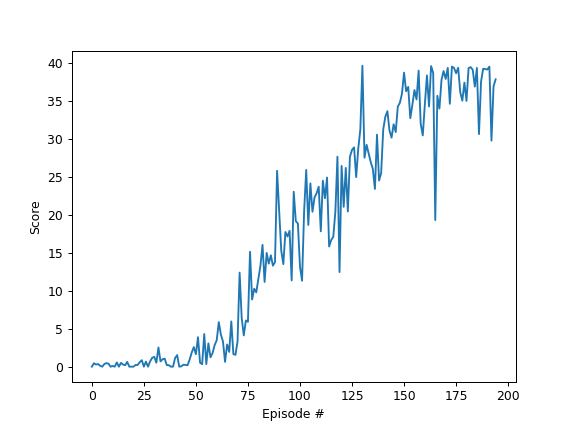

In [23]:
# plot the learning curve
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5 Code

For more details on Soft Actor Critic please read the [following](https://towardsdatascience.com/in-depth-review-of-soft-actor-critic-91448aba63d4) which provided a basis for this implementation.

### agent.py

This is the implementation of the soft actor critic agent. It is calibrated via the hyperparams dictionary. Its main method for training is the `learn_episode (self, max_steps)` method which instructs the agent to run a single episode and learn from it returning the episode score.

| Parameter | Value | Description |
|-----------|-------|-------------|
| gamma | 0.99 | The reward discount |
| tau | 0.005 | A parameter used when updating the target network from the local network which controls the interpolation between the models |
| q_learn_rate | 3e-4 | The learning rate used for updates to the Q networks (critic) |
| policy_learn_rate | 3e-4 | The learning rate used for policy network updates (actor). |
| alpha | 0.2 | Starting value of alpha which controls the degree of entropy based exploration |
| a_learn_rate | 3e-4 | The learning rate used for updates to the alpha value |

The code is structured so that we have a pair of Q networks and we take the minimum from these as the estimate of the Q value to avoid overestimation. For each of these networks we maintain a local and target version of the network to avoid feedback while training. The target version lags the local version using Polyak averaging to update the target version (the hyperparameter `tau` contains the degree of mixing at each step).


### buffer.py

This contains the replay buffer code. The buffer provides for random samples (via the `SimpleBuffer` class).  The basic parameter are


| Parameter | Value | Description |
|-----------|-------|-------------|
| buffer_size | 10000 | The size of the buffer |
| batch_size | 64 | The number of experiences processed in each batch |


### model.py

This contains the neural networks used to run a function approximation for the Q (state / action value) function, `QNetwork` and policy function, `GaussianPolicyNetwork`. The Q network uses three fully connected layers. The sizes of the layers are

| Parameter | Value | Description |
|-----------|-------|-------------|
| q_fc1_units | 256 | The number of units in the first layer |
| q_fc2_units | 256 | The number of units in the second layer |
| q_init_w | 3e-3 | The weights are initialized uniformly in the range (-q_init_w, q_init_w) |

The third layer has 1 unit to output the value of the input state / action combination.

The `GaussianPolicyNetwork` has outputs a mean and log standard deviation for each dimension of the action space in its forward method. It also has a `sample(state)` method which will sample from the resulting distribution to get an action. This network has the following parameters:

| Parameter | Value | Description |
|-----------|-------|-------------|
| p_fc1_units | 256 | The number of units in the first layer |
| p_fc2_units | 256 | The number of units in the second layer |
| p_init_w |  3e-3  | The weights are initialized uniformly in the range (-p_init_w, p_init_w) |
| p_log_std_min | -20 | The minimum for log standard deviation |
| p_log_std_max | 2 | The maximum for log standard deviation  |


## 6 Future Work

Next steps for this project could be looking into hyperparameter tuning for the algorithm possibly via Hyperopt. The project could also be extended to compare this algorithm with alternatives for continuous control such as A2C, A3C and TRPO.